In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:86% !important;}
div.cell.code_cell.rendered{width:100%;}
div.CodeMirror {font-family:Consolas; font-size:15pt;}
div.output {font-size:15pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:15pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:15px;}
</style>
"""))

**<font size="6" color="red">ch9. Transformers</font>**
- 인코더 층만으로 구현(입력: 자연어, 출력:긍정/부정)

# 1. 패키지

In [2]:
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GRU
from time import time #70.1.1 부터 현재까지의 밀리세컨

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# 2. 하이퍼 파라미터 설정(이 파라미터를 바꾸면 정확도나 학습 속도에 차이남)

In [3]:
MY_WORDS  = 10000 # imdb 데이터의 단어수
MY_LENGTH = 80    # 영화평 단어수 80개만 독립변수
MY_EMBED  = 32    # Embeding layer의 결과 차원
MY_HIDDEN = 64    # LSTM의 units 차원

MY_EPOCH  = 10    # 학습 수(fit)
MY_BATCH  = 200   # batch_size(fit시 매번 데이터를 가져오는 데이터)

# 3. 데이터 불러오기

In [4]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=MY_WORDS)

# 4. 문자단어 -> 정수

In [9]:
word_to_id = imdb.get_word_index() # {'word':id}

In [10]:
msg = "What a wonderful movie"
msg = msg.lower().split()
# 1:리뷰시작을 알리는 숫자, 2: 문자가 짤려서 잘못 읽어옴, 3:padding 처리
data = [1] + [word_to_id.get(m, -1)+3 for m in msg]
print('원 후기 내용 : ', msg)
print('encoded된 data :', data)
print('추정된 data :', [id_to_word.get(d-3, '???') for d in data])
print('추정된 data :', ' '.join([id_to_word.get(d-3, '???') for d in data]))

원 후기 내용 :  ['what', 'a', 'wonderful', 'movie']
encoded된 data : [1, 51, 6, 389, 20]
추정된 data : ['???', 'what', 'a', 'wonderful', 'movie']
추정된 data : ??? what a wonderful movie


# 5. 숫자영화평 -> 자연어 영화평 return 함수

In [11]:
def decoding(review_num):
    decoded = [id_to_word.get(num-3, '???') for num in review_num]
    return ' '.join(decoded)

# 6. 영화평(입력 변수)의 길이

In [15]:
def show_length(x_train):
    print('첫 20개 영화평 길이')
    print([len(x_data) for x_data in x_train[:20]])

In [16]:
# pad_sequence 전
show_length(x_train)

첫 20개 영화평 길이
[218, 189, 141, 550, 147, 43, 123, 562, 233, 130, 450, 99, 117, 238, 109, 129, 163, 752, 212, 177]


# 7. 모든 영화평 길이를 동일하게(80)

In [17]:
X_train = pad_sequences(x_train,
                       padding='pre',    # pre : 앞부분 짜르고 뒷부분만 남김
                       truncating='pre', # post : 뒷부분을 짜르고 앞부분을 남김
                       maxlen=MY_LENGTH)
X_test = pad_sequences(x_test,
                       padding='pre',
                       truncating='pre', # post : 뒷부분을 짜르고 앞부분을 남김
                       maxlen=MY_LENGTH)
show_length(X_train), show_length(X_test)

첫 20개 영화평 길이
[80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80]
첫 20개 영화평 길이
[80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80]


(None, None)

# 8. 최종 데이터 shape 확인

In [18]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((25000, 80), (25000,), (25000, 80), (25000,))

# 9. 모델 생성

In [84]:
model = Sequential()
model.add(Embedding(input_dim=MY_WORDS, # 10000
                    output_dim=MY_EMBED, # 32
                    input_length=MY_LENGTH, # 80
                   ))
# RNN : 입력단어의 길이 수가 너무 길면 파라미터 업데이트 안됨
# 개선모델1. LSTM 개선모델2. GRU
model.add(GRU(units=MY_HIDDEN,
              input_shape=(MY_LENGTH, MY_EMBED) # 80, 32
              ))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 80, 32)            320000    
                                                                 
 gru (GRU)                   (None, 64)                18816     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 338,881
Trainable params: 338,881
Non-trainable params: 0
_________________________________________________________________


## 9. 모델 구현(Transformers)

In [22]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
INPUTS = layers.Input(shape=(MY_LENGTH,)) # 80
INPUT_EMBEDDING = layers.Embedding(input_dim=MY_WORDS, # 10000
output_dim=MY_EMBED)(INPUTS)# 32
# Positional Encoding
POSITIONS = tf.range(start=0,
limit=MY_LENGTH)
POS_ENCODING = layers.Embedding(input_dim=MY_LENGTH, output_dim=MY_EMBED)(POSITIONS)
POS_ENC_OUTPUT = POS_ENCODING + INPUT_EMBEDDING
ATTENTION_OUTPUT = layers.MultiHeadAttention(num_heads=3,
key_dim=MY_EMBED)(POS_ENC_OUTPUT,
POS_ENC_OUTPUT)
X = layers.add([POS_ENC_OUTPUT, ATTENTION_OUTPUT])
X = layers.BatchNormalization()(X)
# FeedForward Network
FFN = Sequential([layers.Dense(MY_HIDDEN, activation="relu"),
layers.Dense(MY_EMBED, activation="relu")])(X)
X = layers.add([FFN, X])
X = layers.BatchNormalization()(X)
# 하나의 벡터로 압축해서 Dense로 보내줌
X = layers.GlobalAveragePooling1D()(X)
X = layers.Dropout(0.1)(X)
X = layers.Dense(MY_HIDDEN, activation="relu")(X)
X = layers.Dropout(0.1)(X)
OUTPUTS = layers.Dense(2, activation="softmax")(X)
model = Model(inputs=INPUTS, outputs=OUTPUTS)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 80)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 80, 32)       320000      ['input_2[0][0]']                
                                                                                                  
 tf.__operators__.add_1 (TFOpLa  (None, 80, 32)      0           ['embedding_2[0][0]']            
 mbda)                                                                                            
                                                                                                  
 multi_head_attention_1 (MultiH  (None, 80, 32)      12608       ['tf.__operators__.add_1[0]

# 10. 학습환경 설정 및 학습하기

In [24]:
model.compile(
#     loss='binary_crossentropy', # 이진분류시 손실함수
            loss="sparse_categorical_crossentropy",
              optimizer='adam',
              metrics=['acc']
             )
begin = time() # 70.1.1 부터 현재까지의 밀리세컨
print(begin)
hist = model.fit(X_train,y_train,
                 epochs=MY_EPOCH,
                 batch_size=MY_BATCH,
                 validation_split=0.2,
                 verbose=1
                )
end = time() # 70.1.1 부터 이시점까지의 밀리세컨
print('총 학습시간 :', (end-begin))

1750733936.546477
Epoch 1/10
100/100 [==============================] - 16s 154ms/step - loss: 0.4667 - acc: 0.7760 - val_loss: 0.6219 - val_acc: 0.7270
Epoch 2/10
100/100 [==============================] - 15s 154ms/step - loss: 0.2773 - acc: 0.8861 - val_loss: 0.5536 - val_acc: 0.8342
Epoch 3/10
100/100 [==============================] - 15s 153ms/step - loss: 0.2218 - acc: 0.9133 - val_loss: 0.4818 - val_acc: 0.8112
Epoch 4/10
100/100 [==============================] - 16s 158ms/step - loss: 0.1805 - acc: 0.9305 - val_loss: 0.4212 - val_acc: 0.8128
Epoch 5/10
100/100 [==============================] - 16s 160ms/step - loss: 0.1494 - acc: 0.9424 - val_loss: 0.4866 - val_acc: 0.8004
Epoch 6/10
100/100 [==============================] - 16s 157ms/step - loss: 0.1219 - acc: 0.9495 - val_loss: 0.5328 - val_acc: 0.8064
Epoch 7/10
100/100 [==============================] - 16s 158ms/step - loss: 0.0926 - acc: 0.9625 - val_loss: 0.6398 - val_acc: 0.7926
Epoch 8/10
100/100 [=================

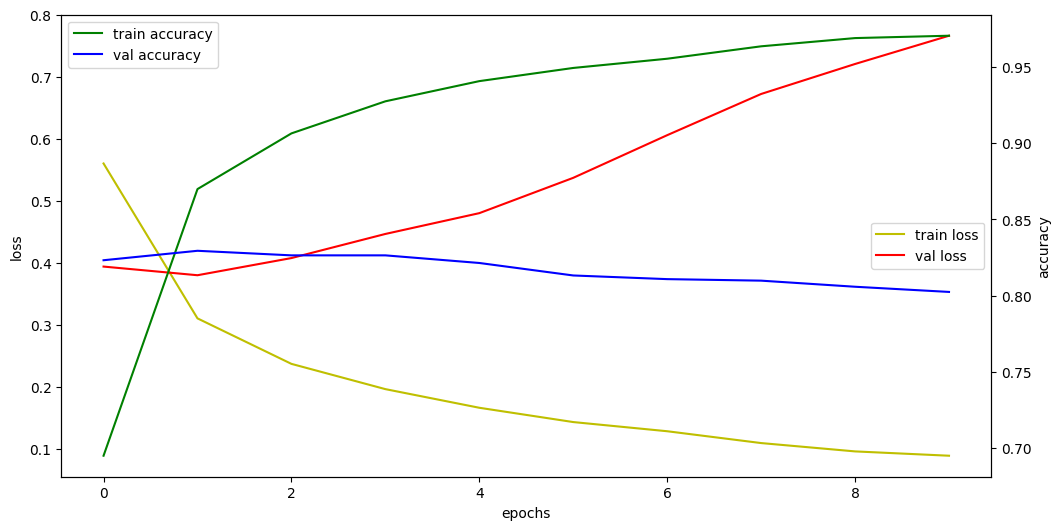

In [87]:
# 5. 모델 학습과정 시각화
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(12,6))
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['acc'], 'g', label='train accuracy')
acc_ax.plot(hist.history['val_acc'], 'b', label='val accuracy')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend()
plt.show()

# 11. 모델 평가

In [88]:
# pad_sequences 'post'
loss, acc = model.evaluate(X_test, y_test)
print('정확도 :', acc)

782/782 [==============================] - 7s 8ms/step - loss: 0.7734 - acc: 0.7981
정확도 : 0.7980800271034241


In [89]:
X_test

array([[   0,    0,    0, ...,   14,    6,  717],
       [1669,  398,  229, ...,  125,    4, 3077],
       [ 687,    2,  203, ...,    9,   57,  975],
       ...,
       [   0,    0,    0, ...,   21,  846, 5518],
       [   8,   97,   14, ..., 2302,    7,  470],
       [ 718,    2,    9, ...,   34, 2005, 2643]])

In [90]:
# 혼동행렬, recall, precision을 위한 yhat
yhat = (model.predict(X_test) > 0.5).astype(np.int16)
yhat

782/782 [==============================] - 6s 8ms/step


array([[0],
       [1],
       [1],
       ...,
       [0],
       [0],
       [1]], dtype=int16)

In [91]:
confusion_matrix(y_test, yhat)

array([[10057,  2443],
       [ 2605,  9895]], dtype=int64)

In [92]:
# recall(실제 True인 것 중 True로 예측한 비율) 10238/(2262+10238)
recall_score(y_test, yhat)

0.7916

In [93]:
# precision(True로 예측한 것 중 실제값이 True인 비율) 10238/(2778+10238)
precision_score(y_test, yhat)

0.8019938401685849

In [94]:
review = """The film is truly a tale of two halves. The first act was definitely entertaining. The world design looked amazing. Sprawling scenery and some genuinely scary moments involving the infected. This part of the film was by far the closest to the previous instalments. The direction here stands out - with grainy close-ups, fast jump cuts, and jarring transitions reminiscent of the original film, it pulls you right into the chaos.

Unfortunately, the momentum doesn't last. As the film transitions into its second half, it shifts gears into a more melodramatic human drama. The focus moves away from the infected threat and toward a lackluster subplot involving a mother and a doctor. The characters at this point make some questionable decisions which really doesn't help the film's validity.

The final act unfortunately teetered on lacklustre and borderline comedic, completely changing the tone of the first act.

I stand by saying the directing, camera work, editing and cinematography were the highlight. The landscapes and post apocalyptic setting was beautiful to look at. These elements made the film worth watching. There were some plot elements that were interesting enough but were never explored to the full potential.

However a weak plot, even weaker characters and a lacklustre ending prevent this instalment from being memorable.
""".lower()
# print(review)
import re
review = re.sub('[^a-zA-Z\']', ' ',review)
# print('영화평(특수문자 제외):', review)
review = [1] + [word_to_id.get(word, -1) + 3 for word in review ]
print(review, len(review))

[1, 830, 2023, 963, 2, 1209, 13, 2014, 1983, 2, 13, 590, 2, 830, 1479, 1206, 2014, 5135, 2, 6, 2, 830, 6, 2014, 963, 2, 1604, 1209, 2, 830, 1992, 1604, 2, 2023, 6, 2014, 1964, 963, 590, 2, 2, 830, 2023, 963, 2, 1209, 13, 1479, 590, 830, 2, 6, 1148, 830, 2, 1992, 6, 590, 2, 1095, 963, 1209, 13, 3363, 13, 830, 963, 2014, 5135, 2, 963, 3363, 830, 963, 1479, 830, 6, 13, 3363, 13, 3363, 1331, 2, 2, 830, 2023, 963, 2, 1992, 1604, 1479, 2014, 1095, 2, 1095, 963, 590, 13, 1331, 3363, 2, 2014, 1604, 1604, 2295, 963, 1095, 2, 6, 1983, 6, 4543, 13, 3363, 1331, 2, 2, 590, 1657, 1479, 6, 1992, 2014, 13, 3363, 1331, 2, 590, 1148, 963, 3363, 963, 1479, 5135, 2, 6, 3363, 1095, 2, 590, 1604, 1983, 963, 2, 1331, 963, 3363, 1206, 13, 3363, 963, 2014, 5135, 2, 590, 1148, 6, 1479, 5135, 2, 1983, 1604, 1983, 963, 3363, 830, 590, 2, 13, 3363, 1964, 1604, 2014, 1964, 13, 3363, 1331, 2, 830, 2023, 963, 2, 13, 3363, 1209, 963, 1148, 830, 963, 1095, 2, 2, 830, 2023, 13, 590, 2, 1657, 6, 1479, 830, 2, 1604, 1209,

In [95]:
input_data = pad_sequences([review],
                       padding='pre',
                       truncating='pre', # post : 뒷부분을 짜르고 앞부분을 남김
                       maxlen=MY_LENGTH)
input_data

array([[2023,    6, 1479,    6, 1148,  830,  963, 1479,  590,    2,    6,
        3363, 1095,    2,    6,    2, 2014,    6, 1148, 2295, 2014, 1206,
         590,  830, 1479,  963,    2,  963, 3363, 1095,   13, 3363, 1331,
           2, 1657, 1479,  963, 1964,  963, 3363,  830,    2,  830, 2023,
          13,  590,    2,   13, 3363,  590,  830,    6, 2014, 1983,  963,
        3363,  830,    2, 1209, 1479, 1604, 1983,    2,  503,  963,   13,
        3363, 1331,    2, 1983,  963, 1983, 1604, 1479,    6,  503, 2014,
         963,    2,    2]])

In [96]:
result = model.predict(input_data).astype('int8').reshape(-1)
result

1/1 [==============================] - 0s 31ms/step


array([0], dtype=int8)